# Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -qU tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.8 MB/s eta 0:00:00


# Import packags

In [3]:
import os
import argparse
import pdb

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST
from tensorboardX import SummaryWriter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

import os

# Setting paths and parameters

In [4]:
data_dir = '/content/drive/MyDrive/chest_xray_small/chest_xray'
weight = '/content/drive/MyDrive/Colab Notebooks/born_again_neuralnet/PneumoniaMobilenetv2.pth'
batch_size = 32
lr = 0.01
n_epoch = 10
n_gen = 3
resume_gen = 0
outdir = "snapshots"
print_interval = 5

# Data loader for x-ray images

No. of training examples for Pneumonia: 250
No. of training examples for Normal: 250
torch.Size([3, 224, 224]) 0
['NORMAL', 'PNEUMONIA']


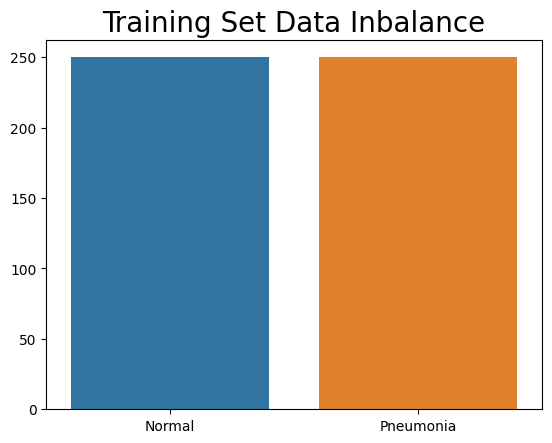

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = "cpu"

transform = transforms.Compose([
    transforms.ToTensor(),
])

############### Dataloader for x-ray image ##################
data_dir = data_dir

pneumonia_files = os.listdir(data_dir + "/train/PNEUMONIA")
print('No. of training examples for Pneumonia:', len(pneumonia_files))
# print(pneumonia_files[:5])

normal_files = os.listdir(data_dir + "/train/NORMAL")
print('No. of training examples for Normal:', len(normal_files))
# print(normal_files[:5])

dataset = ImageFolder(data_dir+'/train',
                      transform=tt.Compose([tt.Resize(255),
                                            tt.CenterCrop(224),
                                            tt.RandomHorizontalFlip(),
                                            tt.RandomRotation(10),
                                            tt.RandomGrayscale(),
                                            tt.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            tt.ToTensor()
                                            #tt.Normalize(mean=[0.485, 0.456, 0.406],
                                            #std=[0.229, 0.224, 0.225] ,inplace=True)
                                          ]))
test_dataset = ImageFolder(data_dir+'/test',
                          transform=tt.Compose([tt.Resize(255),
                                                tt.CenterCrop(224),
                                                tt.ToTensor()
                                                #tt.Normalize(mean=[0.485, 0.456, 0.406],
                                                #             std=[0.229, 0.224, 0.225],
                                                #             inplace=True)
                                                ]))
img, label = dataset[0]
print(img.shape, label)
print(dataset.classes)

# number of images for each class in training
train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(data_dir+'/train/NORMAL', filename)
                    for filename in os.listdir(data_dir+'/train/NORMAL')])],
    'Pneumonia': [len([os.path.join(data_dir+'/train/PNEUMONIA', filename)
                        for filename in os.listdir(data_dir+'/train/PNEUMONIA')])]})

sns.barplot(data=train_samplesize).set_title('Training Set Data Inbalance', fontsize=20)
plt.show()

random_seed = 2020
torch.manual_seed(random_seed);

train_size = round(len(dataset)*0.7) # 70%
val_size = len(dataset) - train_size # 30%

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size, shuffle=False)
##############################################################

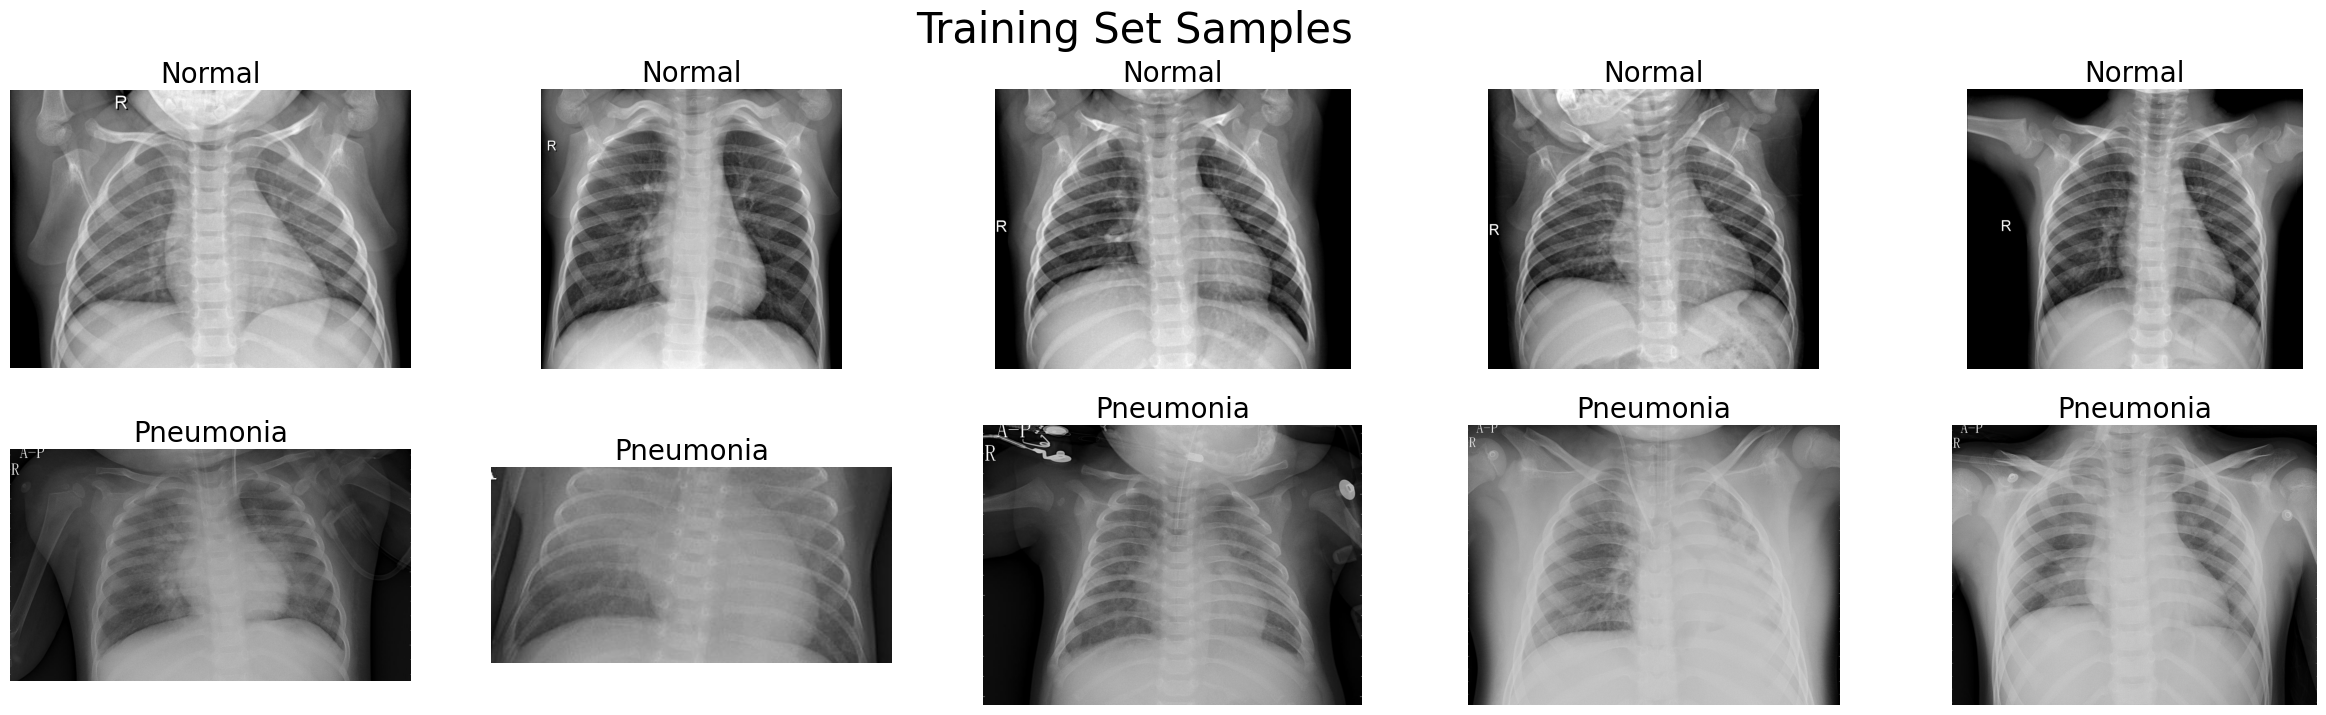

In [6]:
# Function for plotting samples
def plot_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,8))
    for i in range(len(samples)):
        image = cv2.cvtColor(imread(samples[i]), cv2.COLOR_BGR2RGB)
        ax[i//5][i%5].imshow(image)
        if i<5:
            ax[i//5][i%5].set_title("Normal", fontsize=20)
        else:
            ax[i//5][i%5].set_title("Pneumonia", fontsize=20)
        ax[i//5][i%5].axis('off')

## Plot training samples
rand_samples = random.sample([os.path.join(data_dir+'/train/NORMAL', filename)
                              for filename in os.listdir(data_dir+'/train/NORMAL')], 5) + \
    random.sample([os.path.join(data_dir+'/train/PNEUMONIA', filename)
                   for filename in os.listdir(data_dir+'/train/PNEUMONIA')], 5)

plot_samples(rand_samples)
plt.suptitle('Training Set Samples', fontsize=30)
plt.show()

#MobileNet model

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

def F1_score(outputs, labels):
    _, preds = torch.max(outputs, dim=1)

    # precision, recall, and F1
    cm  = confusion_matrix(labels, preds)
    tn, fp, fn, tp = cm.ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*((precision*recall)/(precision+recall))

    return precision,recall,f1,preds

class PneumoniaModelBase(nn.Module):

    def training_step(self, batch, weight):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels, weight=weight)
        acc,preds = accuracy(out, labels)

        return {'train_loss': loss, 'train_acc':acc}

    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['train_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()

        return {'train_loss': epoch_loss.item(), 'train_acc': epoch_acc.item()}

    def validation_step(self, batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc,preds = accuracy(out, labels)

        return {'val_loss': loss.detach(), 'val_acc':acc.detach(),
                'preds':preds.detach(), 'labels':labels.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()

        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, train_result, val_result):
        print('Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.
              format(epoch+1, train_result['train_loss'], train_result['train_acc'],
                     val_result['val_loss'], val_result['val_acc']))

    def test_prediction(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()

        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()]

        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]

        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}

class PneumoniaMobileNetv2(PneumoniaModelBase):
    def __init__(self):
        super().__init__()
        self.network = models.mobilenet_v2(pretrained=True)

        # Freeze training for all layers
        for param in self.network.parameters():
            param.requires_grad = False

        # Get the number of input features for the classifier
        num_features = self.network.classifier[1].in_features

        # Replace the classifier with a new one
        self.network.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_features, 2)  # binary classification
        )

    def forward(self, xb):
        return self.network(xb)

def get_model(model_type=None):
    model = PneumoniaMobileNetv2()
    return model


# BAN Updater

In [ ]:
class BANUpdater(object):
    def __init__(self, **kwargs):
        self.model = kwargs.pop("model")
        self.optimizer = kwargs.pop("optimizer")
        self.n_gen = kwargs.pop("n_gen")
        self.last_model = None
        self.gen = 0

    def update(self, inputs, targets, criterion):
        self.optimizer.zero_grad()
        outputs = self.model(inputs)
        if self.gen > 0:
            if torch.cuda.is_available():
              device = torch.device("cuda")
            else:
              device = "cpu"

            self.last_model.to(device)

            teacher_outputs = self.last_model(inputs).detach()
            loss = self.kd_loss(outputs, targets, teacher_outputs)
        else:
            loss = criterion(outputs, targets)

        loss.backward()
        self.optimizer.step()
        return loss

    def register_last_model(self, weight):
        self.last_model = get_model()
        self.last_model.load_state_dict(torch.load(weight))

    def kd_loss(self, outputs, labels, teacher_outputs, alpha=0.2, T=20):
        KD_loss = nn.KLDivLoss()(F.log_softmax(outputs/T, dim=1),
                                 F.softmax(teacher_outputs/T, dim=1)) * \
            alpha + F.cross_entropy(outputs, labels) * (1. - alpha)

        return KD_loss

    def __model(self):
        return self.model

    def __last_model(self):
        return self.last_model

    def __gen(self):
        return self.gen


# Logger

In [ ]:
class Logger(object):
    def __init__(self, args):
        self.args = args

    def print_args(self):
        print("weight: ", self.args['weight'])
        print("lr: ", self.args['lr'])
        print("n_epoch: ", self.args['n_epoch'])
        print("batch_size: ", self.args['batch_size'])
        print("n_gen: ", self.args['n_gen'])
        print("dataset: ", self.args['dataset'])
        print("outdir: ", self.args['outdir'])
        print("print_interval: ", self.args['print_interval'])

    def print_log(self, epoch, it, train_loss, val_loss):
        print("epoch: {}, iter: {}, train_loss: {}, val_loss: {}".format(
            epoch, it, train_loss, val_loss,
        ))

args = {'weight': weight, 'lr': lr, 'n_epoch': n_epoch, 'batch_size': batch_size,
        'n_gen': n_gen, 'dataset': 'x-ray', 'outdir': outdir,
        'print_interval': print_interval
        }

logger = Logger(args)
logger.print_args()

weight:  /content/drive/MyDrive/Colab\ Notebooks/born_again_neuralnet/PneumoniaMobilenetv2.pth
lr:  0.01
n_epoch:  10
batch_size:  32
n_gen:  3
dataset:  x-ray
outdir:  snapshots
print_interval:  5


# BAN Training

In [ ]:
train_loader = train_dl
test_loader = val_dl

model = get_model(model_type='MobileNetv2').to(device)

if weight:
  loaded_model = torch.load(weight, map_location=torch.device(device))
  model.load_state_dict(loaded_model['state_dict'])

optimizer = optim.Adam(model.parameters(), lr=lr)
kwargs = {
    "model": model,
    "optimizer": optimizer,
    "n_gen": n_gen,
}

writer = SummaryWriter(outdir)
updater = BANUpdater(**kwargs)
criterion = nn.CrossEntropyLoss()

i = 0
best_loss = 1e+9
best_loss_list = []

if not os.path.exists(outdir):
  os.mkdir(outdir)
  print('output directory created: ', outdir)

print("train...")
for gen in range(resume_gen, n_gen):
    for epoch in range(n_epoch):
        train_loss = 0
        for idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            t_loss = updater.update(inputs, targets, criterion).item()
            train_loss += t_loss
            i += 1
            if i % print_interval == 0:
                writer.add_scalar("train_loss", t_loss, i)

                val_loss = 0
                with torch.no_grad():
                    for idx, (inputs, targets) in enumerate(test_loader):
                        inputs, targets = inputs.to(device), targets.to(device)
                        outputs = updater.model(inputs)
                        loss = criterion(outputs, targets).item()
                        val_loss += loss

                val_loss /= len(test_loader)
                if val_loss < best_loss:
                    best_loss = val_loss
                    last_model_weight = os.path.join(outdir,
                                                      "model"+str(gen)+".pth.tar")
                    torch.save(updater.model.state_dict(),
                                last_model_weight)

                writer.add_scalar("val_loss", val_loss, i)

                logger.print_log(epoch, i, train_loss / print_interval, val_loss)
                train_loss = 0

    print("best loss: ", best_loss)
    print("Born Again...")
    updater.register_last_model(last_model_weight)
    updater.gen += 1
    best_loss_list.append(best_loss)
    best_loss = 1e+9
    model = get_model().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    updater.model = model
    updater.optimizer = optimizer

for gen in range(n_gen):
    print("Gen: ", gen,
          ", best val loss: ", best_loss_list[gen])


train...
epoch: 0, iter: 5, train_loss: 1.8676844745874406, val_loss: 1.3910901546478271
epoch: 0, iter: 10, train_loss: 1.1899614617228509, val_loss: 1.6490384340286255
best loss:  1.3910901546478271
Born Again...


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2976: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


epoch: 0, iter: 15, train_loss: 1.7262586236000061, val_loss: 1.5004395246505737
epoch: 0, iter: 20, train_loss: 0.6356549292802811, val_loss: 0.45931950211524963
best loss:  0.45931950211524963
Born Again...
epoch: 0, iter: 25, train_loss: 0.6289235711097717, val_loss: 0.4658462226390839
epoch: 0, iter: 30, train_loss: 0.19291239231824875, val_loss: 0.12628935649991035
best loss:  0.12628935649991035
Born Again...
Gen:  0 , best loss:  1.3910901546478271
Gen:  1 , best loss:  0.45931950211524963
Gen:  2 , best loss:  0.12628935649991035


# Inference

In [ ]:
import os
import glob
import argparse

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST

dataset = 'x-ray'
testloader = test_dl
weights_root = outdir

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = "cpu"

transform = transforms.Compose([
    transforms.ToTensor(),
])

model = get_model().to(device)
weights = glob.glob(os.path.join(weights_root, "*.pth.tar"))

outputs_list = []

def F1_score(outputs, labels):
    # _, preds = torch.max(outputs, dim=1)
    preds = outputs
    # precision, recall, and F1
    cm  = confusion_matrix(labels, preds)
    tn, fp, fn, tp = cm.ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*((precision*recall)/(precision+recall))

    return precision,recall,f1,preds

for weight in weights:
    model.load_state_dict(torch.load(weight))
    model.eval()

    correct = 0
    total = 0
    outputs_of_model = []

    preds_list_f1 = torch.Tensor()
    targets_list_f1 = torch.Tensor()

    with torch.no_grad():
        for idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            outputs_of_model.append(outputs)
            _, pred = outputs.max(1)
            total += targets.size(0)
            correct += pred.eq(targets).sum().item()

            if idx==0:
              preds_list_f1 = pred
              targets_list_f1 = targets
            else:
              preds_list_f1 = torch.cat((preds_list_f1, pred), dim=0)
              targets_list_f1 = torch.cat((targets_list_f1, targets), dim=0)

        outputs_list.append(outputs_of_model)

    acc = 100. * correct / total
    precision, recall, f1, preds = F1_score(preds_list_f1, targets_list_f1)
    print("model:{0}, acc:{1:.2f}, precision:{2:.2f}, recall:{3:.2f}, F1:{4:.2f}".format(
        os.path.basename(weight), acc, precision, recall, f1
        )
    )

# 0 & 1 ensemble
correct = 0
total = 0
preds_list_f1 = torch.Tensor()
targets_list_f1 = torch.Tensor()

for idx, (inputs, targets) in enumerate(testloader):
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = (outputs_list[0][idx] + outputs_list[1][idx]) / 2
    _, pred = outputs.max(1)
    total += targets.size(0)
    correct += pred.eq(targets).sum().item()
    if idx==0:
        preds_list_f1 = pred
        targets_list_f1 = targets
    else:
        preds_list_f1 = torch.cat((preds_list_f1, pred), dim=0)
        targets_list_f1 = torch.cat((targets_list_f1, targets), dim=0)

outputs_list.append(outputs_of_model)

acc = 100. * correct / total
precision, recall, f1, preds = F1_score(preds_list_f1, targets_list_f1)
print("model:{0}, acc:{1:.2f}, precision:{2:.2f}, recall:{3:.2f}, F1:{4:.2f}".format(
    "0+1", acc, precision, recall, f1
    )
)

# 0 & 1 & 2 ensemble
correct = 0
total = 0

preds_list_f1 = torch.Tensor()
targets_list_f1 = torch.Tensor()

for idx, (inputs, targets) in enumerate(testloader):
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = (outputs_list[0][idx] + outputs_list[1][idx] + outputs_list[2][idx]) / 3
    _, pred = outputs.max(1)
    total += targets.size(0)
    correct += pred.eq(targets).sum().item()

    if idx==0:
        preds_list_f1 = pred
        targets_list_f1 = targets
    else:
        preds_list_f1 = torch.cat((preds_list_f1, pred), dim=0)
        targets_list_f1 = torch.cat((targets_list_f1, targets), dim=0)

outputs_list.append(outputs_of_model)

acc = 100. * correct / total
precision, recall, f1, preds = F1_score(preds_list_f1, targets_list_f1)
print("model:{0}, acc:{1:.2f}, precision:{2:.2f}, recall:{3:.2f}, F1:{4:.2f}".format(
    "0+1+2", acc, precision, recall, f1
    )
)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


model:model2.pth.tar, acc:50.00, precision:0.50, recall:1.00, F1:0.67
model:model0.pth.tar, acc:54.50, precision:0.52, recall:0.99, F1:0.69
model:model1.pth.tar, acc:50.00, precision:0.50, recall:1.00, F1:0.67
model:0+1, acc:51.50, precision:0.51, recall:1.00, F1:0.67
model:0+1+2, acc:50.00, precision:0.50, recall:1.00, F1:0.67
